In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
def bigshow(img=np.zeros((100,100)), title='Image', size=12):
    plt.figure(figsize=[size, size])
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

# 1. Introdução

Neste trabalho, propõe-se a implementação de uma rede neural convolucional que efetua a super-resolução de uma imagem bidimensional. 

A aplicação final dessa metodologia será tornar factível a reconstrução tomográfica de um imagem, que seria impraticável em condições normais, devido à alta resolução da imagem final.

Um exemplo disto é o caso de imageamento por difração coerente (CDI em inglês). Para a reconstrução de grandes volumes, e para que estas sejam feitas em tempo hábil, é necessário que isso seja feito com o auxílio do poder de processamento paralelo de GPUs. A contrapartida é que a memória disponível nas GPUs disponíveis no mercado atualmente limita as dimensões deste volume. Entretanto, neste trabalho, serão utilizados volumes de imagens com dimensões limitadas, em comparação com as amostras coletadas originalmente, para fins de demonstração.

Em tese, não há um limite bem definido para qual resolução física uma imagem pode ser super-resolvida. No entanto, para que se obtenha dados mais próximos do real, a resolução do _upscaling_ é limitada por uma correlação denominada FSC -- Fourier Shell Correlation.

Para fins de demonstração, neste trabalho, será aplicada a super-resolução em escala de 2 vezes, ou seja, para o dobro da resolução da imagem de entrada.

Apesar de dados tomográficos serem tridimensionais, a princípio, a técnica será aplicada em cada imagem (2D) que compõe um volume (3D) -- as fatias -- pois muitas análises e técnicas de segmentação também são feitas sobre as fatias. 

# 2. Materiais e métodos

## 2.1. Dados experimentais

Os dados iniciais consistem de experimentos de tomografia computadorizada, realizados na linha de luz IMX do Laboratório Nacional de Luz Síncrotron em que foram adquiridas projeções em variados ângulos. São 3 amostras de diferentes objetos.

As medidas foram realizadas nos seguintes objetos:
- Ponta de caneta esferográfica;
- Palito de madeira;
- Espinho de planta;

Originalmente, as medidas de cada amostra resultaram em projeções de 2048 ângulos, com cada projeção tendo dimensões de 2048 pixels de altura, 2048 pixels de largura e 8 bits de profundidade. 

Estas projeções são os dados brutos que, em seu estado original, acabam resultando em arquivos de aproximadamente 8 gigabytes ($(2048\times2048\times2048\times2)/(1024^3)=8GB$). 

Para processar esses dados, seriam necessários recursos de memória, processamento e armazenamento impraticáveis para a disciplina, principalmente para que a reprodutibilidade seja possível para todos os colegas.

Portanto, para fins de experimento e de reprodutibilidade para a disciplina, foi feita uma subamostragem dos dados brutos. Todos foram reduzidos para 512 ângulos e 512 pixels de altura e largura, resultando em arquivos de aproximadamente 250MB.



### 2.1.1. Dados brutos

Os dados brutos são gravados em um arquivo com nome padrão, _tomo.h5_. Abaixo pode ser verificada uma projeção da amostra. Esses dados serão disponibilizados apenas para fins informativos, pois os dados reconstruídos estarão todos disponíveis para _download_.

A reconstrução desses dados requer um software especial para tal fim, portanto esse procedimento não será contemplado por este trabalho.

In [3]:
pick_dir = '../data/ia369z/Palito'
final_size = os.path.getsize(pick_dir + '/tomo.h5')/(1024**2)
print('Tamanho final do arquivo bruto: {0:.2f} MB'.format(final_size))

Tamanho final do arquivo bruto: 250.50 MB


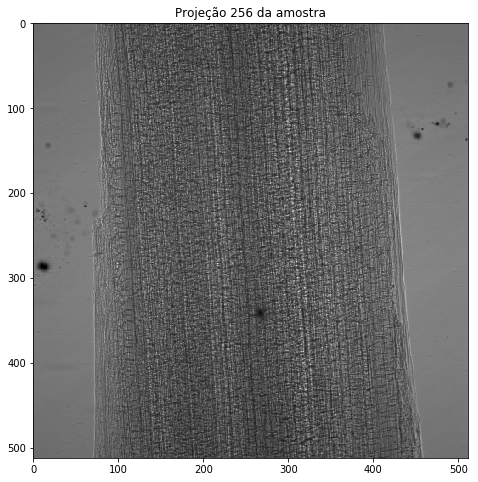

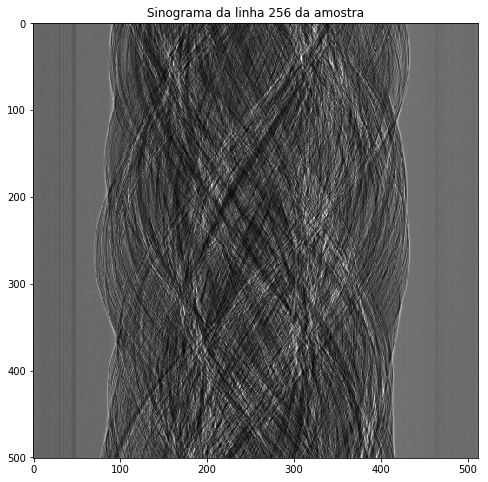

In [4]:
tomo = np.zeros((512, 512))
with h5.File(pick_dir + '/tomo.h5', 'r') as h5tomo:
    tomo = np.copy(h5tomo['images'])
    
bigshow(tomo[256], 'Projeção 256 da amostra', size=8)
bigshow(tomo[:, 256, :], 'Sinograma da linha 256 da amostra', size=8)

### 2.1.2. Reconstrução
Após adquiridas as projeções, é necessário realizar a reconstrução tomográfica, para que se possa obter as imagens tridimensionais das amostras. 

Com o método de reconstrução tomográfica utilizado, é gerado um arquivo por fatia do volume tridimensional. Nas dimensões apresentadas, cada arquivo tem tamanho aproximado de 260 kilobytes.

Abaixo pode-se verificar a visualização de uma projeção e o corte em diferentes ângulos da imagem reconstruída.

In [5]:
os.path.getsize(pick_dir + '/recon/slice_0.b')/1024

256.0

In [6]:
cut_l = np.zeros((501, 512))

for l in range(501):
    cut_l[l] = np.fromfile(pick_dir + '/recon/slice_{}.b'.format(l), dtype='uint8').reshape((512, 512))[256]

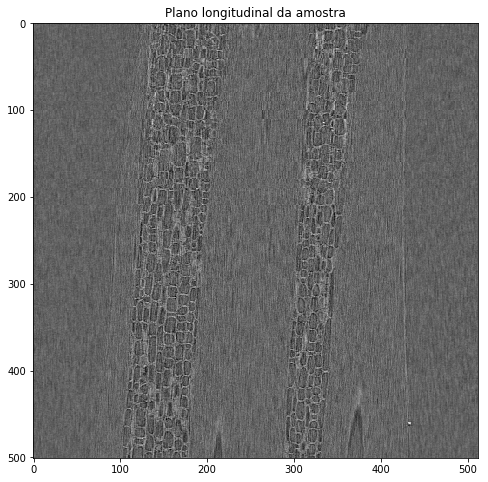

In [7]:
bigshow(cut_l, 'Plano longitudinal da amostra', size=8)

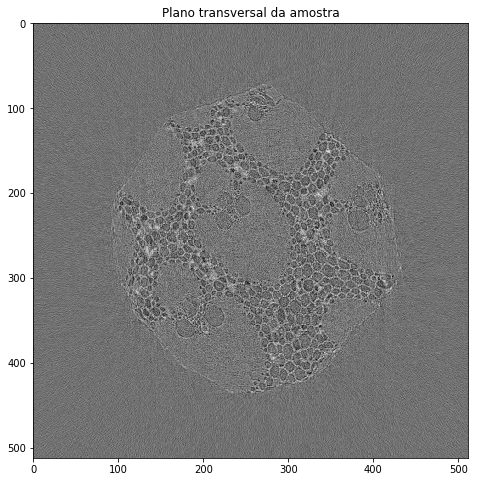

In [8]:
cut_t = np.fromfile(pick_dir + '/recon/slice_256.b'.format(l), dtype='uint8').reshape((512, 512))
bigshow(cut_t, 'Plano transversal da amostra', size=8)

## 2.2. Metodologia

### 2.2.1. _Upscaling_

As reconstruções apresentadas são as imagens em resultado ideal, com a resolução que se espera alcançar com o experimento proposto por este projeto.

Para o experimento, foram feitas subamostragens dos dados brutos que, por sua vez, passaram pela reconstrução tomográfica, que então foram submetidas ao processo de _upscaling_.

Ao final, os dados reconstruídos são volumes de 512 pixels cúbicos, para as imagens _ground truth_ e 256 pixels cúbicos para as as imagens reconstruídas a partir do dado subamostrado. Ou seja, reconstruções na escala maior, com 512x512x512 pixels serviram como _ground truth_ para a rede convolucional utilizada.

### 2.2.2. Redes Neurais Convolucionais

Redes neurais convolucionais (CNN na sigla em inglês), assim como outras redes neurais artificiais, são baseadas em observações na natureza. Neste caso, especificamente, na arquitetura do córtex visual de seres capazes de enxergar. 

Experimentos realizados com algumas espécies de animais concluíram que os neurônios responsáveis pelo processamento visual apenas reagem a estímulos em regiões limitadas do campo visual.

Neste sentido, assim como a percepção visual observada nesses experimentos, em uma rede neural convolucional, os neurônios de uma camada não estão conectados a todos os neurônios da camada anterior, mas em uma região de interesse, limitada pela arquitetura da rede.

###

# Referências

[1] Elias Nehme, Lucien E. Weiss, Tomer Michaeli, and Yoav Shechtman, "Deep-STORM: super-resolution single-molecule microscopy by deep learning," Optica 5, 458-464 (2018)

[2] C. Dong, C. C. Loy, K. He, and X. Tang, “Image super-resolution usingdeep convolutional networks,”IEEE Transactions on Pattern Analysisand Machine Intelligence, vol. 38, pp. 295–307, Feb 2016.

Referências faltantes:
LNLS
Experimento com córtex visual
Tomografia
CDI
Fourier shell correlation
CNN
ANN
SRCNN
O'Reilly hands on machine learning